In [ ]:
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152']

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


In [ ]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    # 3x3 conv + padding 1
    # return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
    return mnn.MaskConv2d(in_planes, out_planes, kernel_size=3, stride=stride, 
                          padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    # 1x1 conv
    # return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)
    return mnn.MaskConv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

#### BasicBlock & BottleNeck

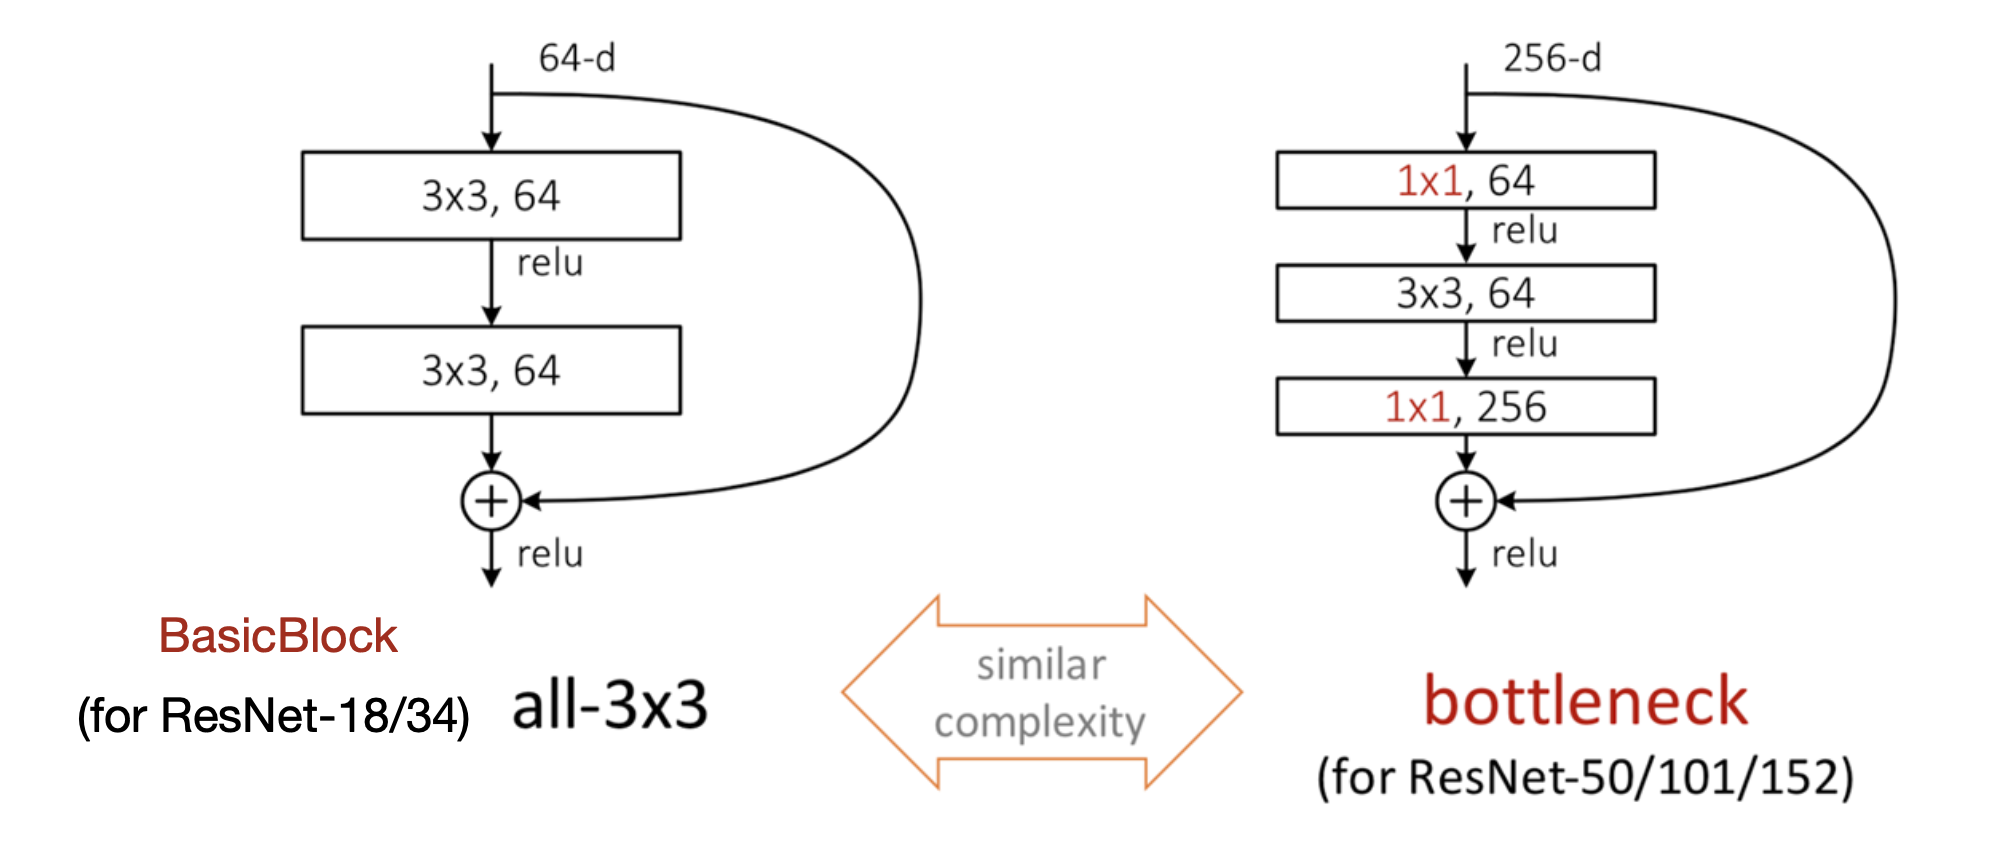

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']
    
    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 & base_width=64')
        if dilation > 1:
            raise NotImplementedError('Dilation > 1 is not supported in BasicBlock')

        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1   = norm_layer(planes)      # nn.BatchNorm2d(planes)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2   = norm_layer(planes)      # nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        # first block
        out = self.conv1(x)     # 3x3 (stride = 입력된 stride)
        out = self.bn1(out)     # batch norm
        out = self.relu(out)
        # second block
        out = self.conv2(out)   # 3x3 (stride = 1)
        out = self.bn2(out)     # batch norm

        if self.downsample is not None:
            # stride가 1이 아닐 경우 identity 크기 조절 필요 (out과 더하기 위해)
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)

        return out

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=4, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups

        self.conv1 = conv1x1(inplanes, width)
        self.bn1   = norm_layer(width)                      # nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)    # conv3x3(planes, planes, stride)
        self.bn2   = norm_layer(width)                      # nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3   = norm_layer(planes * self.expansion)    # nn.BatchNorm2d(planes * self.expansion)
        self.relu  = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        # first block
        out = self.conv1(x)     # 1x1 (stride = 1)
        out = self.bn1(out)
        out = self.relu(out)
        # second block
        out = self.conv2(out)   # 3x3 (stride = stride)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)   # 1x1 (self.expansion)
        out = self.bn3(out)

        if self.downsample is not None:
            # stride가 1이 아닐 경우 identity 크기 조절 필요 (out과 더하기 위해)
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

#### ResNet

In [ ]:
class ResNet(nn.Module):
    # ex) ResNet(Bottleneck, [3,4,6,3], **kwargs)
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None, norm_layer=None):
        super(ResNet, self).__init__()
        self.block_name = str(block.__name__)
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1

        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None or 3-element tuple,"
                             "got {}".format(replace_stride_with_dilation))
            
        self.groups = groups
        self.base_width = width_per_group
        
        # input  = 3  x 224 x 224
        # nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1 = mnn.MaskConv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        # output = 64 x 112 x 112

        self.bn1   = norm_layer(self.inplanes)      # nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        
        # input  = 64 x 112 x 112
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # output = 64 x 56  x 56

        self.layer1 = self._make_layer(block, 64,  layers[0])              # 3
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])   # 4
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])   # 6
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])   # 3

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            # weight 초기화
            if isinstance(m, mnn.MaskConv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        # ex) self._make_layer(Bottleneck, 64, 3)
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation

        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            # stride = 1 or 64 != 64 * 4
            downsample = nn.Sequential(conv1x1(self.inplanes, planes * block.expansion, stride),   # conv1x1(64, 256, stride=1)
                                       norm_layer(planes * block.expansion),                       # BatchNorm2d(256)
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample,
                            self.groups, self.base_width, previous_dilation, norm_layer))    # Bottleneck(64, 64, 1, downsample)

        self.inplanes = planes * block.expansion      # self.inplanes = 256

        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation, norm_layer=norm_layer))

        return nn.Sequential(*layers)
        '''
        self.layer1 = [
            Bottleneck(64, 64, 1, downsample),
            Bottleneck(256, 64),
            Bottleneck(256, 64),
        ]

        self.layer2 = [
            Bottleneck(256, 128, 2, downsample),
            Bottleneck(512, 128),
            Bottleneck(512, 128),
            Bottleneck(512, 128),
        ]
        '''

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x,1)    # x.view(x.size(0), -1) : 일렬로 펼쳐주기
        x = self.fc(x)

        return x

In [ ]:
class ResNet_CIFAR(nn.Module):
    # ex) ResNet(Bottleneck, [3,4,6,3], **kwargs)
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None, norm_layer=None):
        super(ResNet_CIFAR, self).__init__()
        self.block_name = str(block.__name__)
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 16      # 기존 : 64
        self.dilation = 1

        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None or 3-element tuple,"
                             "got {}".format(replace_stride_with_dilation))
            
        self.groups = groups
        self.base_width = width_per_group
        
        # input  = 3  x 224 x 224
        # nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # mnn.MaskConv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1 = mnn.MaskConv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        # output = 64 x 112 x 112

        self.bn1   = norm_layer(self.inplanes)      # nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        
        # input  = 64 x 112 x 112
        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # output = 64 x 56  x 56

        self.layer1 = self._make_layer(block, 64,  layers[0])              # 3
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])   # 4
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])   # 6
        # self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])   # 3

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(64 * block.expansion, num_classes)     # nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            # weight 초기화
            if isinstance(m, mnn.MaskConv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        # ex) self._make_layer(Bottleneck, 64, 3)
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation

        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            # stride = 1 or 64 != 64 * 4
            downsample = nn.Sequential(conv1x1(self.inplanes, planes * block.expansion, stride),   # conv1x1(64, 256, stride=1)
                                       norm_layer(planes * block.expansion),                       # BatchNorm2d(256)
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample,
                            self.groups, self.base_width, previous_dilation, norm_layer))    # Bottleneck(64, 64, 1, downsample)

        self.inplanes = planes * block.expansion      # self.inplanes = 256

        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation, norm_layer=norm_layer))

        return nn.Sequential(*layers)
        '''
        self.layer1 = [
            Bottleneck(64, 64, 1, downsample),
            Bottleneck(256, 64),
            Bottleneck(256, 64),
        ]

        self.layer2 = [
            Bottleneck(256, 128, 2, downsample),
            Bottleneck(512, 128),
            Bottleneck(512, 128),
            Bottleneck(512, 128),
        ]
        '''

    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x,1)    # x.view(x.size(0), -1) : 일렬로 펼쳐주기
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

In [ ]:
cfgs = {
    '18' : (BasicBlock, [2,2,2,2]),
    '34' : (BasicBlock, [3,4,6,3]),
    '50' : (BasicBlock, [3,4,6,3]),
    '101': (BasicBlock, [3,4,23,3]),
    '152': (BasicBlock, [3,8,36,3]),
}

cfgs_cifar = {
    '20' : [3,3,3],
    '32' : [5,5,5],
    '20' : [7,7,7],
    '20' : [9,9,9],
    '20' : [18,18,18],
}

In [ ]:
def resnet(data='cifar10', **kwargs):
    num_layers = str(kwargs.get('num_layers'))

    global mnn
    mnn = kwargs.get('mnn')
    assert mnn is not None, "Please specify proper pruning method"

    if data in ['cifar10', 'cifar100']:
        if num_layers in cfgs_cifar.keys():
            model = ResNet_CIFAR(BasicBlock, cfgs_cifar[num_layers], int(data[5:]))
        else:
            model = None
        image_size = 32
    elif data == 'imagenet':
        if num_layers in cfgs.keys():
            block, layers = cfgs[num_layers]
            model = ResNet(block, layers, 1000)
        else:
            model = None
        image_size = 224
    else:
        model = None
        image_size = None
    
    return model, image_size